# Computing Vision Movie Data Exploration & Analysis

## Table of Contents
1. <a href='#import'>Import Packages</a>
2. <a href='#data'>Data Exploration & Cleaning</a> <br>
<t>2.1. <a href='#imdb-data'>IMDB Data</a><br>
<t>2.2. <a href='#budgets-data'>Budgets Data</a><br>
<t>2.3. <a href='#bom-data'>BOM Data</a><br>
<t>2.4. <a href='#bom-budgets-data'>Merge BOM & budgets data</a><br>
<t>2.5. <a href='#join-data'>Filter & Join IMDB Genre Data</a><br>
&ensp;&ensp;2.4.1. <a href='#avg-gross'>Average Gross Domestic by Genre</a><br>
&ensp;&ensp;2.4.2. <a href='#avg-ratings'>Average Ratings by Genre</a> <br>
&ensp;&ensp;2.4.3. <a href='#avg-budget'>Average Production Budget by Genre</a> <br>
&ensp;&ensp;2.4.4. <a href='#ogvs'>Original vs. Non-Original Movies</a> <br>
3. <a href='#stat-analysis'>Statistical Analysis</a><br>
&ensp;3.1. <a href='#mean-filter'>Mean Filter</a> <br>
&ensp;3.2. <a href='#msa'>Mean Statistical Analysis</a> <br>
&ensp;3.3. <a href='#sav'>Statistical Analysis Visualizations</a> <br>

<a id='import'></a>
# Import Packages

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.float_format', lambda x: '%.2f' % x)

<a id='data'></a>
# Data Exploration & Cleaning

<a id='imdb-data'></a>
## IMDB Data

In [2]:
conn = sqlite3.connect("./data/im.db")

In [3]:
imdb_movie_info = pd.read_sql("""SELECT * FROM movie_basics;""", conn)

In [4]:
imdb_movie_info.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.00,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.00,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.00,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,nan,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.00,"Comedy,Drama,Fantasy"


(array([ 0.,  2.,  4.,  6.,  8., 10., 12.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

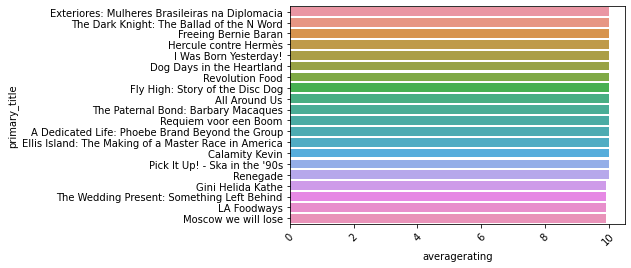

In [5]:
rating = pd.read_sql("""
SELECT *
  FROM movie_basics mb
  INNER JOIN movie_ratings mr ON mb.movie_id=mr.movie_id;
""", conn)

sns.barplot(
    x='averagerating',
    y='primary_title',
    data=rating.nlargest(20, 'averagerating')
)
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45)

# many movies have an average rating of 10

In [6]:
pd.read_sql("""
SELECT primary_title, genres, averagerating
  FROM movie_basics mb
  INNER JOIN movie_ratings mr ON mb.movie_id=mr.movie_id
  GROUP BY mb.movie_id
  HAVING numvotes > 10000
  ORDER BY averagerating DESC
  LIMIT 20;
""", conn)

# drama appears a lot in this query result (1,000 numvotes)
# action appears a lot when numvotes is changed to 10,000; action seems very popular in the database file

,primary_title,genres,averagerating
0,The Mountain II,"Action,Drama,War",9.30
1,Aynabaji,"Crime,Mystery,Thriller",9.30
2,Wheels,Drama,9.30
3,CM101MMXI Fundamentals,"Comedy,Documentary",9.20
4,O.J.: Made in America,"Biography,Crime,Documentary",8.90
5,Ratsasan,"Action,Crime,Thriller",8.80
6,96,"Drama,Romance",8.80
7,Avengers: Endgame,"Action,Adventure,Sci-Fi",8.80
8,Drishyam,"Crime,Drama,Thriller",8.80
9,Inception,"Action,Adventure,Sci-Fi",8.80


In [7]:
# assessing runtime and finding the top 200 rated movies' runtimes
runtime = pd.read_sql("""
SELECT primary_title, runtime_minutes, averagerating
  FROM movie_basics mb
  INNER JOIN movie_ratings mr ON mb.movie_id=mr.movie_id
  GROUP BY mb.movie_id
  HAVING numvotes > 10000
  ORDER BY averagerating DESC
  LIMIT 200;
""", conn)

runtime.head()

,primary_title,runtime_minutes,averagerating
0,The Mountain II,135.00,9.30
1,Aynabaji,147.00,9.30
2,Wheels,115.00,9.30
3,CM101MMXI Fundamentals,139.00,9.20
4,O.J.: Made in America,467.00,8.90


In [8]:
runtime.mean()

# popular movies are about 2 hours long

runtime_minutes   131.85
averagerating       8.16
dtype: float64

Text(0, 0.5, 'Average Rating')

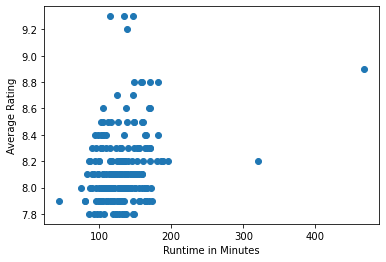

In [9]:
# Understanding the relationship between average rating an runtime in minutes
plt.scatter(runtime['runtime_minutes'], runtime['averagerating'])
plt.xlabel('Runtime in Minutes')
plt.ylabel('Average Rating')

# the top 200 rated movies are concentrated between runtimes of 100 and 200 with very few outside of the maximum bound

### Top Movies by # Votes

In [10]:
top_movies_by_votes = pd.read_sql("""SELECT genres, primary_title, averagerating, start_year, numvotes
                                FROM movie_basics
                                JOIN movie_ratings
                                    USING(movie_id)
                                ORDER BY numvotes DESC
;""", conn)

In [11]:
top_movies_by_votes

,genres,primary_title,averagerating,start_year,numvotes
0,"Action,Adventure,Sci-Fi",Inception,8.80,2010,1841066
1,"Action,Thriller",The Dark Knight Rises,8.40,2012,1387769
2,"Adventure,Drama,Sci-Fi",Interstellar,8.60,2014,1299334
3,"Drama,Western",Django Unchained,8.40,2012,1211405
4,"Action,Adventure,Sci-Fi",The Avengers,8.10,2012,1183655
...,...,...,...,...,...
73851,Comedy,Columbus,5.80,2018,5
73852,"Comedy,Horror",BADMEN with a good behavior,9.20,2018,5
73853,Romance,July Kaatril,9.00,2019,5
73854,Documentary,Swarm Season,6.20,2019,5


### Top Movies by Average Rating

In [12]:
top_movies_by_rating = pd.read_sql("""SELECT genres, primary_title, averagerating, start_year, numvotes
                                FROM movie_basics
                                JOIN movie_ratings
                                    USING(movie_id)
                                ORDER BY numvotes DESC
;""", conn)

### Top Genres by Count

In [13]:
top_genres_by_count = pd.read_sql("""SELECT genres, COUNT(*) as amount
                                        FROM movie_basics
                                        GROUP BY GENRES
                                        ORDER BY amount DESC
;""", conn)

In [14]:
top_genres_by_count

,genres,amount
0,Documentary,32185
1,Drama,21486
2,Comedy,9177
3,None,5408
4,Horror,4372
...,...,...
1081,"Action,Animation,Music",1
1082,"Action,Animation,History",1
1083,"Action,Animation,Documentary",1
1084,"Action,Animation,Biography",1


### Top Genres by Rating

In [15]:
top_genres_by_rating = pd.read_sql("""SELECT genres, AVG(averagerating) as average_rating
                                        FROM movie_basics
                                        JOIN movie_ratings
                                            USING(movie_id)
                                        GROUP BY GENRES
                                        ORDER BY average_rating DESC
;""", conn)

In [16]:
top_genres_by_rating

,genres,average_rating
0,"Comedy,Documentary,Fantasy",9.40
1,"Documentary,Family,Musical",9.30
2,"History,Sport",9.20
3,"Music,Mystery",9.00
4,Game-Show,9.00
...,...,...
919,"Crime,Music",2.40
920,"History,Sci-Fi,Thriller",2.30
921,"Adventure,Crime,Romance",2.30
922,"Adult,Horror",2.00


<a id='budgets-data'></a>
## Budgets Data

In [17]:
# Movie Budgets Data
budgets = pd.read_csv('./data/tn.movie_budgets.csv.gz')
budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [18]:
budgets.info()

# cleaning necessary for budgets data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [19]:
# to change release date into a date type
budgets['release_date'] = pd.to_datetime(budgets['release_date'])
budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   object        
 4   domestic_gross     5782 non-null   object        
 5   worldwide_gross    5782 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 271.2+ KB


In [20]:
# to change dollar variables into integer types
budgets[budgets.columns[3:]] = budgets[budgets.columns[3:]].apply(lambda x: x.str.replace('$','')).apply(lambda x: x.str.replace(',','')).astype(np.int64)

In [21]:
budgets.info()

# integer conversion successful

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   int64         
 4   domestic_gross     5782 non-null   int64         
 5   worldwide_gross    5782 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 271.2+ KB


In [22]:
# Understanding more about production budget variable in dataset
budgets['production_budget'].describe()

count        5782.00
mean     31587757.10
std      41812076.83
min          1100.00
25%       5000000.00
50%      17000000.00
75%      40000000.00
max     425000000.00
Name: production_budget, dtype: float64

In [23]:
# Understanding more about domestic gross variable in dataset
budgets['domestic_gross'].describe()

count        5782.00
mean     41873326.87
std      68240597.36
min             0.00
25%       1429534.50
50%      17225945.00
75%      52348661.50
max     936662225.00
Name: domestic_gross, dtype: float64

In [24]:
# Understanding more about worldwide gross variable in dataset
budgets['worldwide_gross'].describe()

count         5782.00
mean      91487460.91
std      174719968.78
min              0.00
25%        4125414.75
50%       27984448.50
75%       97645836.50
max     2776345279.00
Name: worldwide_gross, dtype: float64

<AxesSubplot:xlabel='production_budget', ylabel='domestic_gross'>

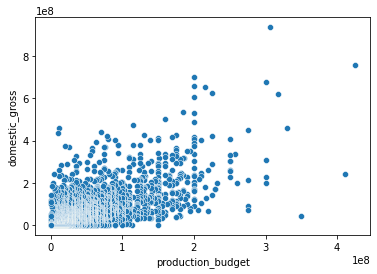

In [25]:
# How do production budget and domestic gross interact?
import seaborn as sns
sns.scatterplot(x = 'production_budget', y ='domestic_gross', data = budgets)

# very loose upward relationship between domestic gross and production budget; the more budget, generally the higher the
#     gross domestic income.

(array([0.0e+00, 5.0e+07, 1.0e+08, 1.5e+08, 2.0e+08, 2.5e+08, 3.0e+08,
        3.5e+08, 4.0e+08, 4.5e+08]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

C:\Users\myhansen\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\myhansen\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\myhansen\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 128 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\myhansen\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 153 missing from current font.
  font.set_text(s, 0, flags=flags)


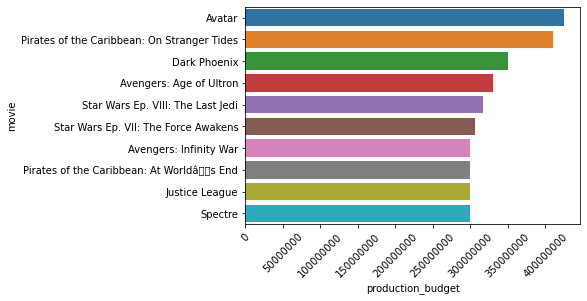

In [26]:
# top 10 movies by production budget
sns.barplot(
    x='production_budget',
    y='movie',
    data=budgets.nlargest(10, 'production_budget')
)
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45)

(array([0.e+00, 2.e+08, 4.e+08, 6.e+08, 8.e+08, 1.e+09]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

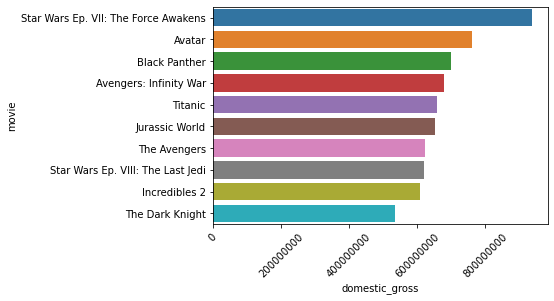

In [27]:
# top 10 movies by domestic gross income
sns.barplot(
    x='domestic_gross',
    y='movie',
    data=budgets.nlargest(10, 'domestic_gross')
)
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45)


# about half of these movies were not in the top 10 movies by production budget
#     (Titanic, Jurassic World, The Avengers, Incredibles 2, Black Panther)
# Star Wars: The Force Awakens jumps to top domestic gross income earner, despite being number 6 in the production budget

(array([0.0e+00, 5.0e+08, 1.0e+09, 1.5e+09, 2.0e+09, 2.5e+09, 3.0e+09]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

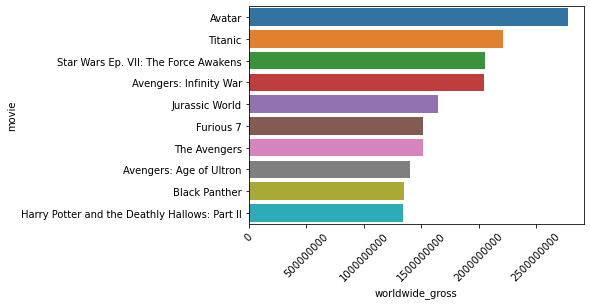

In [28]:
# top 10 movies by worldwide gross income
sns.barplot(
    x='worldwide_gross',
    y='movie',
    data=budgets.nlargest(10, 'worldwide_gross')
)
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45)

# Avatar and Titanic preform better with international audiences; most of the movies are simialr to domestic gross
#     Haryy Potter and Furious 7 join in the group
# We can infer that many movies preform the same in the worldwide gross category; international movie goers appear to
#     have similar prefernces to that of domestic movie goers.

In [29]:
# Domestic gross seems to be the largest earning area for movies - analysis on addressing the key question to closely 
#     consider the tastes/preferneces of domestic movie watchers over international, especially since many of the same
#     movie favorites in the United States are also movie favorites abroad.

# Determine what makes these movies popular OTHER than production budget. Movies do not have to spend a lot of money
#     to make a lot of money in the domestic box office; seek to understand movie characteristics.

<a id='bom-data'></a>
## BOM Data & Cleaning

In [30]:
bom = pd.read_csv('./data/bom.movie_gross.csv.gz')

In [31]:
bom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


In [32]:
# To merge bom and budgets data

bom_budgets = pd.merge(budgets, bom, how='inner',
                  left_on='movie', right_on='title')
bom_budgets.head(50)

# Note: many movies in the budget dataset will be lost in the inner join

,id,release_date,movie,production_budget,domestic_gross_x,worldwide_gross,title,studio,domestic_gross_y,foreign_gross,year
0,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,Pirates of the Caribbean: On Stranger Tides,BV,241100000.00,804600000,2011
1,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,Avengers: Age of Ultron,BV,459000000.00,946400000,2015
2,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,Avengers: Infinity War,BV,678800000.00,"1,369.5",2018
3,9,2017-11-17,Justice League,300000000,229024295,655945209,Justice League,WB,229000000.00,428900000,2017
4,10,2015-11-06,Spectre,300000000,200074175,879620923,Spectre,Sony,200100000.00,680600000,2015
5,11,2012-07-20,The Dark Knight Rises,275000000,448139099,1084439099,The Dark Knight Rises,WB,448100000.00,636800000,2012
6,12,2018-05-25,Solo: A Star Wars Story,275000000,213767512,393151347,Solo: A Star Wars Story,BV,213800000.00,179200000,2018
7,13,2013-07-02,The Lone Ranger,275000000,89302115,260002115,The Lone Ranger,BV,89300000.00,171200000,2013
8,14,2012-03-09,John Carter,275000000,73058679,282778100,John Carter,BV,73100000.00,211100000,2012
9,15,2010-11-24,Tangled,260000000,200821936,586477240,Tangled,BV,200800000.00,391000000,2010


In [33]:
bom_budgets.info()

# incomplete information on foreign_gross
# some inconsistencies between domestic_gross, but potentially not material

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1247 entries, 0 to 1246
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 1247 non-null   int64         
 1   release_date       1247 non-null   datetime64[ns]
 2   movie              1247 non-null   object        
 3   production_budget  1247 non-null   int64         
 4   domestic_gross_x   1247 non-null   int64         
 5   worldwide_gross    1247 non-null   int64         
 6   title              1247 non-null   object        
 7   studio             1246 non-null   object        
 8   domestic_gross_y   1245 non-null   float64       
 9   foreign_gross      1086 non-null   object        
 10  year               1247 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(5), object(4)
memory usage: 116.9+ KB


In [34]:
top_studio = bom_budgets['domestic_gross_x'].groupby(by=bom_budgets['studio']).sum()
top_studio.nlargest(10)

# the highest earning domestic grossing movie studios: top 4 are pretty far ahead of the others
# BV (Disney), Universal, Fox, Warner Brothers

studio
BV         12926142171
Uni.       10706840840
Fox         9410233951
WB          9130527872
Sony        7059959451
Par.        6007203309
WB (NL)     3417630150
LGF         3332464750
P/DW        1682914686
LG/S        1499805058
Name: domestic_gross_x, dtype: int64

In [35]:
# average studio domestic gross 

avg_domgross = bom_budgets['domestic_gross_x'].groupby(by=bom_budgets['studio']).mean()
avg_domgross.nlargest(10)

# Disney makes the most revenue on average

studio
BV        179529752.38
P/DW      168291468.60
Sony       95404857.45
WB (NL)    92368382.43
Uni.       91511460.17
WB         89514979.14
Fox        85547581.37
MGM        82992874.00
Par.       81178423.09
Strand     75395035.00
Name: domestic_gross_x, dtype: float64

(array([0.0e+00, 5.0e+07, 1.0e+08, 1.5e+08, 2.0e+08, 2.5e+08, 3.0e+08]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

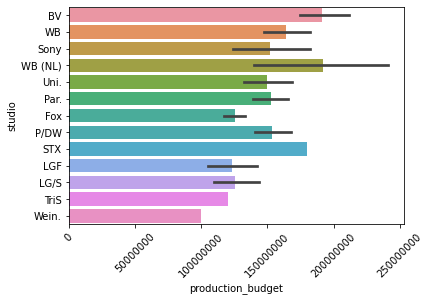

In [36]:
# the top 200 spending movies came from these studios
sns.barplot(
    x='production_budget',
    y='studio',
    data=bom_budgets.nlargest(200, 'production_budget')
)
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45)

In [37]:
# are there similarities between the studios who earned the most in domestic gorss and those who had large production budgets?
top_studio_spend = bom_budgets['production_budget'].groupby(by=bom_budgets['studio']).sum()
top_studio_spend.nlargest(10)

# the highest spending movie studios are similar to those that earned the most money is domestic gross income;
#     this top 10 is also the same

studio
BV         9450800000
WB         8197700000
Fox        7755500000
Uni.       6597700000
Sony       5050500000
Par.       4770000000
WB (NL)    2148600000
LGF        2069387650
LG/S       1658350000
P/DW       1334000000
Name: production_budget, dtype: int64

In [38]:
# average studio spend on production 

avg_prod_budget = bom_budgets['production_budget'].groupby(by=bom_budgets['studio']).mean()
avg_prod_budget.nlargest(10)

# DreamWorks is the biggest average spender; barely over Walt Disney
# Hunch: use a statistical test to determine how much to spend on a movie to get some outcome in domestic gross

studio
P/DW      133400000.00
BV        131261111.11
WB         80369607.84
Fox        70504545.45
NM         70000000.00
Sony       68250000.00
Par.       64459459.46
WB (NL)    58070270.27
Uni.       56390598.29
LG/S       53495161.29
Name: production_budget, dtype: float64

(array([0.e+00, 1.e+08, 2.e+08, 3.e+08, 4.e+08, 5.e+08, 6.e+08, 7.e+08,
        8.e+08]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

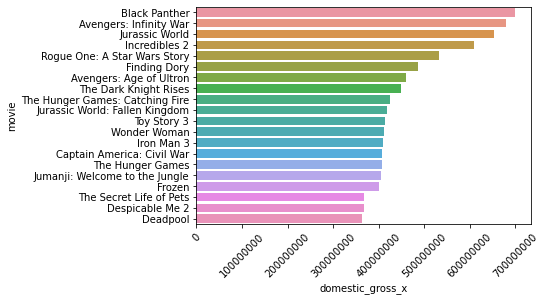

In [39]:
# top 20 domestic grossing movies
sns.barplot(
    x='domestic_gross_x',
    y='movie',
    data=bom_budgets.nlargest(20, 'domestic_gross_x')
)
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45)

In [40]:
bom_budgets.nlargest(20, 'domestic_gross_x')

# the top movies were mostly from the top studios
# all of these top movies are either superheroes, based on books, remakes of a classic, part of a series
# very little "original" content, more so just based upon things that are already popular/known by public

# inner join filtered out Star Wars and Avatar, which is actually the top domestic grossing movie* 
#     because of no match in bom data

# one recommendation could be that Computing Vision reimagine movie classics or create movies based on book favorites 
# superheroes also seem to be popular - they could form creative content around superheroes
# Computing Vision could also make movies children might like, based off of their favorite stories or characters

,id,release_date,movie,production_budget,domestic_gross_x,worldwide_gross,title,studio,domestic_gross_y,foreign_gross,year
25,42,2018-02-16,Black Panther,200000000,700059566,1348258224,Black Panther,BV,700100000.00,646900000,2018
2,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,Avengers: Infinity War,BV,678800000.00,"1,369.5",2018
21,34,2015-06-12,Jurassic World,215000000,652270625,1648854864,Jurassic World,Uni.,652300000.00,"1,019.4",2015
26,44,2018-06-15,Incredibles 2,200000000,608581744,1242520711,Incredibles 2,BV,608600000.00,634200000,2018
27,45,2016-12-16,Rogue One: A Star Wars Story,200000000,532177324,1049102856,Rogue One: A Star Wars Story,BV,532200000.00,523900000,2016
28,46,2016-06-17,Finding Dory,200000000,486295561,1021215193,Finding Dory,BV,486300000.00,542300000,2016
1,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,Avengers: Age of Ultron,BV,459000000.00,946400000,2015
5,11,2012-07-20,The Dark Knight Rises,275000000,448139099,1084439099,The Dark Knight Rises,WB,448100000.00,636800000,2012
126,38,2013-11-22,The Hunger Games: Catching Fire,130000000,424668047,864868047,The Hunger Games: Catching Fire,LGF,424700000.00,440300000,2013
65,13,2018-06-22,Jurassic World: Fallen Kingdom,170000000,417719760,1305772799,Jurassic World: Fallen Kingdom,Uni.,417700000.00,891800000,2018


In [41]:
foreign_dropped = bom[~bom['foreign_gross'].isnull()]['foreign_gross']

In [42]:
bom = bom.dropna(how='any',axis=0) 

In [43]:
bom.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2007 entries, 0 to 3353
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           2007 non-null   object 
 1   studio          2007 non-null   object 
 2   domestic_gross  2007 non-null   float64
 3   foreign_gross   2007 non-null   object 
 4   year            2007 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 94.1+ KB


In [44]:
bom['foreign_gross'].astype('str')

0       652000000
1       691300000
2       664300000
3       535700000
4       513900000
          ...    
3275      1500000
3286       229000
3309       256000
3342         5200
3353        30000
Name: foreign_gross, Length: 2007, dtype: object

In [45]:
bom['foreign_gross']=bom['foreign_gross'].str.replace(',','')

In [46]:
bom['foreign_gross'] = bom['foreign_gross'].astype(float)

<a id='bom-budgets-data'></a>
## Merge BOM and Budgets Data

In [47]:
budgets = pd.read_csv('./data/tn.movie_budgets.csv.gz')
budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [48]:
budgets['release_date'] = pd.to_datetime(budgets['release_date'])

In [49]:
# to change dollar variables into integer types
budgets[budgets.columns[3:]] = budgets[budgets.columns[3:]].apply(lambda x: x.str.replace('$','')).apply(lambda x: x.str.replace(',','')).astype(np.int64)

In [50]:
bom_budgets1 = pd.merge(budgets, bom, how='left',
                  left_on='movie', right_on='title')
bom_budgets1.head(10)

,id,release_date,movie,production_budget,domestic_gross_x,worldwide_gross,title,studio,domestic_gross_y,foreign_gross,year
0,1,2009-12-18,Avatar,425000000,760507625,2776345279,NaN,NaN,nan,nan,nan
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,Pirates of the Caribbean: On Stranger Tides,BV,241100000.00,804600000.00,2011.00
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,NaN,NaN,nan,nan,nan
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,Avengers: Age of Ultron,BV,459000000.00,946400000.00,2015.00
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,NaN,NaN,nan,nan,nan
5,6,2015-12-18,Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,NaN,NaN,nan,nan,nan
6,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,Avengers: Infinity War,BV,678800000.00,1369.50,2018.00
7,8,2007-05-24,Pirates of the Caribbean: At Worldâs End,300000000,309420425,963420425,NaN,NaN,nan,nan,nan
8,9,2017-11-17,Justice League,300000000,229024295,655945209,Justice League,WB,229000000.00,428900000.00,2017.00
9,10,2015-11-06,Spectre,300000000,200074175,879620923,Spectre,Sony,200100000.00,680600000.00,2015.00


In [51]:
top_100 = bom_budgets1.nlargest(100, 'domestic_gross_x')

In [52]:
top_100.head()

,id,release_date,movie,production_budget,domestic_gross_x,worldwide_gross,title,studio,domestic_gross_y,foreign_gross,year
5,6,2015-12-18,Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,NaN,NaN,nan,nan,nan
0,1,2009-12-18,Avatar,425000000,760507625,2776345279,NaN,NaN,nan,nan,nan
41,42,2018-02-16,Black Panther,200000000,700059566,1348258224,Black Panther,BV,700100000.00,646900000.00,2018.00
6,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,Avengers: Infinity War,BV,678800000.00,1369.50,2018.00
42,43,1997-12-19,Titanic,200000000,659363944,2208208395,NaN,NaN,nan,nan,nan


In [53]:
top_movie_titles = set(top_movies_by_votes.primary_title)

In [54]:
same_movies = []
for movie in top_100.title:
    if movie in top_movie_titles:
        same_movies.append(movie)

In [55]:
len(same_movies)

43

<a id='join-data'></a>
## Filter & Join IMDB Genre Data

In [56]:
filtered_imdb = top_movies_by_votes[top_movies_by_votes.primary_title.isin(same_movies)]

In [57]:
filtered_imdb.head()

,genres,primary_title,averagerating,start_year,numvotes
0,"Action,Adventure,Sci-Fi",Inception,8.80,2010,1841066
1,"Action,Thriller",The Dark Knight Rises,8.40,2012,1387769
7,"Action,Adventure,Comedy",Guardians of the Galaxy,8.10,2014,948394
8,"Action,Adventure,Comedy",Deadpool,8.00,2016,820847
9,"Action,Adventure,Sci-Fi",The Hunger Games,7.20,2012,795227


In [58]:
merged = pd.merge(left=filtered_imdb,right=top_100, how='left',      
left_on='primary_title', right_on='movie')

In [59]:
merged

,genres,primary_title,averagerating,start_year,numvotes,id,release_date,movie,production_budget,domestic_gross_x,worldwide_gross,title,studio,domestic_gross_y,foreign_gross,year
0,"Action,Adventure,Sci-Fi",Inception,8.80,2010,1841066,38,2010-07-16,Inception,160000000,292576195,835524642,Inception,WB,292600000.00,535700000.00,2010.00
1,"Action,Thriller",The Dark Knight Rises,8.40,2012,1387769,11,2012-07-20,The Dark Knight Rises,275000000,448139099,1084439099,The Dark Knight Rises,WB,448100000.00,636800000.00,2012.00
2,"Action,Adventure,Comedy",Guardians of the Galaxy,8.10,2014,948394,14,2014-08-01,Guardians of the Galaxy,170000000,333172112,770867516,Guardians of the Galaxy,BV,333200000.00,440200000.00,2014.00
3,"Action,Adventure,Comedy",Deadpool,8.00,2016,820847,56,2016-02-12,Deadpool,58000000,363070709,801025593,Deadpool,Fox,363100000.00,420000000.00,2016.00
4,"Action,Adventure,Sci-Fi",The Hunger Games,7.20,2012,795227,38,2012-03-23,The Hunger Games,80000000,408010692,677923379,The Hunger Games,LGF,408000000.00,286400000.00,2012.00
5,"Adventure,Family,Fantasy",The Hobbit: An Unexpected Journey,7.90,2012,719629,19,2012-12-14,The Hobbit: An Unexpected Journey,250000000,303003568,1017003568,The Hobbit: An Unexpected Journey,WB (NL),303000000.00,718100000.00,2012.00
6,"Drama,Sci-Fi,Thriller",Gravity,7.70,2013,710018,16,2013-10-04,Gravity,110000000,274092705,693698673,Gravity,WB,274100000.00,449100000.00,2013.00
7,"Action,Adventure,Sci-Fi",Iron Man 3,7.20,2013,692794,48,2013-05-03,Iron Man 3,200000000,408992272,1215392272,Iron Man 3,BV,409000000.00,805800000.00,2013.00
8,"Adventure,Animation,Comedy",Toy Story 3,8.30,2010,682218,47,2010-06-18,Toy Story 3,200000000,415004880,1068879522,Toy Story 3,BV,415000000.00,652000000.00,2010.00
9,"Action,Adventure,Sci-Fi",Avengers: Infinity War,8.50,2018,670926,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,Avengers: Infinity War,BV,678800000.00,1369.50,2018.00


In [60]:
genres_grouped = merged.groupby(by=["genres"]).mean()

In [61]:
genres_grouped = genres_grouped.reset_index()
genres_grouped

,genres,averagerating,start_year,numvotes,id,production_budget,domestic_gross_x,worldwide_gross,domestic_gross_y,foreign_gross,year
0,"Action,Adventure,Animation",7.70,2018.00,203510.00,44.00,200000000.00,608581744.00,1242520711.00,608600000.00,634200000.00,2018.00
1,"Action,Adventure,Comedy",7.76,2016.40,577341.20,41.00,121600000.00,348080352.20,834009976.60,346880000.00,483440000.00,2016.40
2,"Action,Adventure,Fantasy",6.78,2016.75,465200.75,52.25,183750000.00,350771365.75,895397046.50,350800000.00,546750000.00,2016.75
3,"Action,Adventure,Sci-Fi",7.27,2014.35,606287.94,37.18,193270588.24,428900617.59,1073269963.35,428900000.00,506953081.70,2014.35
4,"Action,Adventure,Thriller",7.80,2012.00,592221.00,52.00,200000000.00,304360277.00,1110526981.00,304400000.00,804200000.00,2012.00
5,"Action,Biography,Drama",7.30,2014.00,401915.00,57.00,58000000.00,350126372.00,547326372.00,350100000.00,197300000.00,2014.00
6,"Action,Crime,Thriller",7.20,2015.00,335074.00,67.00,190000000.00,353007020.00,1518722794.00,353000000.00,1163.00,2015.00
7,"Action,Thriller",8.40,2012.00,1387769.00,11.00,275000000.00,448139099.00,1084439099.00,448100000.00,636800000.00,2012.00
8,"Adventure,Animation,Comedy",7.45,2014.25,379066.12,53.12,137500000.00,384032986.75,1032316721.88,384037500.00,648350000.00,2014.25
9,"Adventure,Drama,Fantasy",5.00,2010.00,211733.00,53.00,68000000.00,300531751.00,706102828.00,300500000.00,398000000.00,2010.00


<a id='avg-gross'></a>
### Average Gross Domestic by Genre

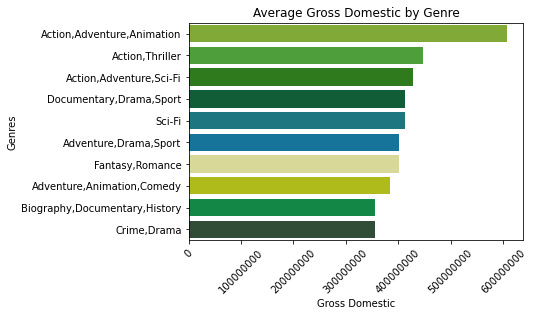

In [62]:
colors = [(134/255, 188/255, 37/255), (67/255, 176/255, 42/255), (38/255, 137/255, 13/255), (4/255, 106/255, 56/255), (13/255, 131/255, 144/255), (0/255, 124/255, 176/255), (227/255, 228/255, 141/255), (196/255, 214/255, 0), (0, 154/255, 68/255), (44/255, 82/255, 52/255), (160/255, 220/255, 255/255)]

sns.barplot(
    x='domestic_gross_x',
    y='genres',
    data=genres_grouped.nlargest(10, 'domestic_gross_x'),
    palette=colors
)
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45)
plt.ylabel('Genres')
plt.xlabel('Gross Domestic')
plt.title('Average Gross Domestic by Genre')
plt.savefig('./screenshots/average-gross.png')
plt.show()

<a id='avg-ratings'></a>
### Average Ratings by Genre

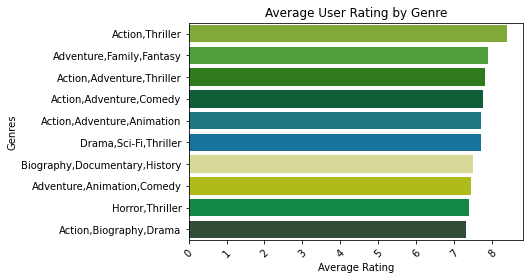

In [63]:
sns.barplot(
    x='averagerating',
    y='genres',
    data=genres_grouped.nlargest(10, 'averagerating'),
    palette=colors
)
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45)
plt.ylabel('Genres')
plt.xlabel('Average Rating')
plt.title('Average User Rating by Genre')
plt.savefig('./screenshots/average-ratings.png')
plt.show()

<a id='avg-budget'></a>
### Average Production Budget by Genre

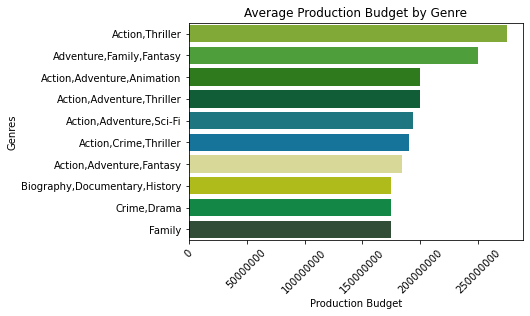

In [64]:
sns.barplot(
    x='production_budget',
    y='genres',
    data=genres_grouped.nlargest(10, 'production_budget'),
    palette=colors
)
plt.ticklabel_format(style='plain', axis='x')
plt.xticks(rotation=45)
plt.ylabel('Genres')
plt.xlabel('Production Budget')
plt.title('Average Production Budget by Genre')
plt.show()

<a id='ogvs'></a>
### Original vs. Non-Original Movies

In [65]:
# Create additional column for original vs non-original movies
originals = [1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0]
top_movies = filtered_imdb.reset_index()
top_movies['original'] = originals
top_movies.head()

,index,genres,primary_title,averagerating,start_year,numvotes,original
0,0,"Action,Adventure,Sci-Fi",Inception,8.80,2010,1841066,1
1,1,"Action,Thriller",The Dark Knight Rises,8.40,2012,1387769,0
2,7,"Action,Adventure,Comedy",Guardians of the Galaxy,8.10,2014,948394,0
3,8,"Action,Adventure,Comedy",Deadpool,8.00,2016,820847,0
4,9,"Action,Adventure,Sci-Fi",The Hunger Games,7.20,2012,795227,0


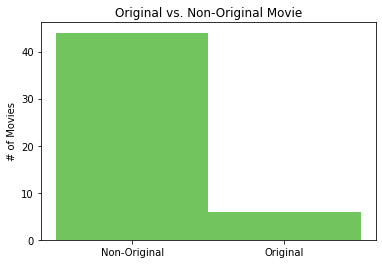

In [66]:
hist = sns.histplot(top_movies['original'], bins=2, discrete=True, color='#43B02A', edgecolor=None)
plt.title('Original vs. Non-Original Movie')
plt.xticks([0,1], ['Non-Original', 'Original'])
plt.xlabel('')
plt.ylabel('# of Movies')
plt.savefig('./screenshots/original-non.png')
plt.show()

<a id='stat-analysis'></a>
## Statistical Analysis 

## What variables are statistically significant?

### How much does Computing Vision have to spend for the production budget in order to reach a target gross domestic income? 

## Movie Budgets Data

In [67]:
# Load in budgets data
budgets = pd.read_csv('./data/tn.movie_budgets.csv.gz')
budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [68]:
budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [69]:
# to change release date into a date type
budgets['release_date'] = pd.to_datetime(budgets['release_date'])
budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   object        
 4   domestic_gross     5782 non-null   object        
 5   worldwide_gross    5782 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 271.2+ KB


In [70]:
# to change dollar variables into integer types
budgets[budgets.columns[3:]] = budgets[budgets.columns[3:]].apply(lambda x: x.str.replace('$','')).apply(lambda x: x.str.replace(',','')).astype(np.int64)

In [71]:
budgets.info()

# integer conversion successful

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   int64         
 4   domestic_gross     5782 non-null   int64         
 5   worldwide_gross    5782 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 271.2+ KB


## BOM Movie Data

In [72]:
# load in and clean bom movie data
bom = pd.read_csv('./data/bom.movie_gross.csv.gz')
bom = bom.dropna(how='any',axis=0) 
bom['foreign_gross'].astype('str')
bom['foreign_gross']=bom['foreign_gross'].str.replace(',','')
bom['foreign_gross'] = bom['foreign_gross'].astype(float)

In [73]:
bom_budgets1 = pd.merge(budgets, bom, how='left',
                  left_on='movie', right_on='title')
bom_budgets1

,id,release_date,movie,production_budget,domestic_gross_x,worldwide_gross,title,studio,domestic_gross_y,foreign_gross,year
0,1,2009-12-18,Avatar,425000000,760507625,2776345279,NaN,NaN,nan,nan,nan
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,Pirates of the Caribbean: On Stranger Tides,BV,241100000.00,804600000.00,2011.00
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,NaN,NaN,nan,nan,nan
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,Avengers: Age of Ultron,BV,459000000.00,946400000.00,2015.00
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,NaN,NaN,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...
5777,78,2018-12-31,Red 11,7000,0,0,NaN,NaN,nan,nan,nan
5778,79,1999-04-02,Following,6000,48482,240495,NaN,NaN,nan,nan,nan
5779,80,2005-07-13,Return to the Land of Wonders,5000,1338,1338,NaN,NaN,nan,nan,nan
5780,81,2015-09-29,A Plague So Pleasant,1400,0,0,NaN,NaN,nan,nan,nan


<a id='sap'></a>
## Statistical Analysis Prepwork

### Computing Vision knows they want to focus on creating action movies specifically and wants to better understand how much of a production budget they should plan for when making their first action movie. This prepwork involves combining financial data with genre data, in hopes of arriving at a good estimate for the production budget planning.

In [74]:
# Obtaining movie titles
top_15000 = bom_budgets1.nlargest(5000, 'domestic_gross_x')
top_movie_titles = set(top_movies_by_votes.primary_title)

In [75]:
# Understanding which movie titles are shared between the budgets & bom data and IMDB database
same_movies = []
for movie in top_15000.title:
    if movie in top_movie_titles:
        same_movies.append(movie)

In [76]:
len(same_movies)

# there are 998 movies in the budgets & bom data and IMDB database

998

In [77]:
filtered_imdb = top_movies_by_votes[top_movies_by_votes.primary_title.isin(same_movies)]
filtered_imdb

,genres,primary_title,averagerating,start_year,numvotes
0,"Action,Adventure,Sci-Fi",Inception,8.80,2010,1841066
1,"Action,Thriller",The Dark Knight Rises,8.40,2012,1387769
2,"Adventure,Drama,Sci-Fi",Interstellar,8.60,2014,1299334
3,"Drama,Western",Django Unchained,8.40,2012,1211405
5,"Biography,Crime,Drama",The Wolf of Wall Street,8.20,2013,1035358
...,...,...,...,...,...
72391,Drama,The Other Side of the Door,3.80,2014,5
72406,Crime,Split,6.80,2016,5
72729,Thriller,Buried,6.00,2011,5
72802,Thriller,The Call,6.60,2014,5


In [78]:
# combining the genres with the financial data from budgets and bom
merged = pd.merge(left=filtered_imdb,right=top_15000, how='left',      
left_on='primary_title', right_on='movie')

In [79]:
# drop null values
merged = merged.dropna()

In [80]:
# filtering for genres that contain 'action'
filtered_genres_action = merged[merged["genres"].str.contains("Action")]
filtered_genres_action

,genres,primary_title,averagerating,start_year,numvotes,id,release_date,movie,production_budget,domestic_gross_x,worldwide_gross,title,studio,domestic_gross_y,foreign_gross,year
0,"Action,Adventure,Sci-Fi",Inception,8.80,2010,1841066,38,2010-07-16,Inception,160000000,292576195,835524642,Inception,WB,292600000.00,535700000.00,2010.00
1,"Action,Thriller",The Dark Knight Rises,8.40,2012,1387769,11,2012-07-20,The Dark Knight Rises,275000000,448139099,1084439099,The Dark Knight Rises,WB,448100000.00,636800000.00,2012.00
6,"Action,Adventure,Comedy",Guardians of the Galaxy,8.10,2014,948394,14,2014-08-01,Guardians of the Galaxy,170000000,333172112,770867516,Guardians of the Galaxy,BV,333200000.00,440200000.00,2014.00
7,"Action,Adventure,Comedy",Deadpool,8.00,2016,820847,56,2016-02-12,Deadpool,58000000,363070709,801025593,Deadpool,Fox,363100000.00,420000000.00,2016.00
8,"Action,Adventure,Sci-Fi",The Hunger Games,7.20,2012,795227,38,2012-03-23,The Hunger Games,80000000,408010692,677923379,The Hunger Games,LGF,408000000.00,286400000.00,2012.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1141,Action,Collide,5.50,2010,12,13,2017-02-24,Collide,29200000,2280004,5466698,Collide,ORF,2300000.00,2500000.00,2017.00
1158,"Action,Sci-Fi,Thriller",The Gambler,6.10,2019,10,25,2014-12-10,The Gambler,25000000,33680992,38718031,The Gambler,Par.,33700000.00,5600000.00,2014.00
1159,"Action,Sci-Fi,Thriller",The Gambler,6.10,2019,10,50,1999-08-04,The Gambler,3000000,51773,101773,The Gambler,Par.,33700000.00,5600000.00,2014.00
1169,"Action,Sport",Stronger,8.40,2016,8,90,2017-09-22,Stronger,30000000,4211129,8786752,Stronger,RAtt.,4200000.00,4200000.00,2017.00


In [81]:
# Understanding the domestic gross income for action movies, to be used to filter on next
filtered_genres_action['domestic_gross_x'].describe()

# data is not normally distributed and is positively skewed (median < mean)
# for this analysis, we will use the median value ($55,833,596.50) to filter movies and make this the "goal" for Computing Vision

count         354.00
mean     99478358.79
std     116434570.17
min         51773.00
25%      26494644.50
50%      55833596.50
75%     129691943.25
max     700059566.00
Name: domestic_gross_x, dtype: float64

<a id='mean-filter'></a>
## Mean Filter
### Using the action movies mean gross domestic income value as the target for Computing Vision in the statistical analysis. 

In [82]:
# filter out movies that have made greater than or equal to this mean threshold.
# Action movies made $99,478,358.79 on average and Computing Vision would like to make at least this much.
filtered_genres2 = filtered_genres_action[filtered_genres_action['domestic_gross_x'] >= 99478358.79]
filtered_genres2

,genres,primary_title,averagerating,start_year,numvotes,id,release_date,movie,production_budget,domestic_gross_x,worldwide_gross,title,studio,domestic_gross_y,foreign_gross,year
0,"Action,Adventure,Sci-Fi",Inception,8.80,2010,1841066,38,2010-07-16,Inception,160000000,292576195,835524642,Inception,WB,292600000.00,535700000.00,2010.00
1,"Action,Thriller",The Dark Knight Rises,8.40,2012,1387769,11,2012-07-20,The Dark Knight Rises,275000000,448139099,1084439099,The Dark Knight Rises,WB,448100000.00,636800000.00,2012.00
6,"Action,Adventure,Comedy",Guardians of the Galaxy,8.10,2014,948394,14,2014-08-01,Guardians of the Galaxy,170000000,333172112,770867516,Guardians of the Galaxy,BV,333200000.00,440200000.00,2014.00
7,"Action,Adventure,Comedy",Deadpool,8.00,2016,820847,56,2016-02-12,Deadpool,58000000,363070709,801025593,Deadpool,Fox,363100000.00,420000000.00,2016.00
8,"Action,Adventure,Sci-Fi",The Hunger Games,7.20,2012,795227,38,2012-03-23,The Hunger Games,80000000,408010692,677923379,The Hunger Games,LGF,408000000.00,286400000.00,2012.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,"Action,Animation,Comedy",The Angry Birds Movie,6.30,2016,69624,77,2016-05-20,The Angry Birds Movie,73000000,107509366,352327887,The Angry Birds Movie,Sony,107500000.00,244800000.00,2016.00
761,"Action,Adventure,Thriller",Robin Hood,5.30,2018,41588,39,2010-05-14,Robin Hood,210000000,105487148,322459006,Robin Hood,Uni.,105300000.00,216400000.00,2010.00
1044,"Action,Drama,Sport",Split,5.40,2016,189,50,2017-01-20,Split,5000000,138141585,278964806,Split,Uni.,138300000.00,140200000.00,2017.00
1065,"Action,Drama",Robin Hood,6.30,2013,78,39,2010-05-14,Robin Hood,210000000,105487148,322459006,Robin Hood,Uni.,105300000.00,216400000.00,2010.00


In [83]:
filtered_genres2['production_budget'].describe()

# production budget spending for this subset of data. Mean and standard deviation to be used for statistical analysis
#     to see if the production budget values Computing Vision was thinking about using will generate at least the mean
#     gross domestic income (i.e. comes from the same distribution).

count         117.00
mean    150681196.58
std      70235544.51
min       5000000.00
25%     104000000.00
50%     150000000.00
75%     190000000.00
max     410600000.00
Name: production_budget, dtype: float64

<a id='msa'></a>
### Mean Statistical Analysis

In [84]:
# Let's say that Computing Vision wants to make the mean ($99,478,358.79) amount fot gross domestic income on
#     their first film.
# Computing Vision believes a modest budget of $25,000,000 will be enough to reach their goal. Is this true?

# Ho: A production budget of $25,000,000 is not enough to make the mean amount of gross income. (mu <= x-bar)
# Ha: A production budget of $25,000,000 is enough to make the mean amount of gross income. (mu > x-bar)

# significance is alpha = 0.05 (95% confidence)

In [85]:
# computing z-statistic using the population production budget mean and standard deviation
x_barm = 25000000 # sample mean 
nm = 117 # number of movies
sigmam = 70235544.51 # sd of population
mum = 150681196.58 # Population mean 

zm = (x_barm - mum)/(sigmam/np.sqrt(nm))
zm

-19.35558420422045

In [86]:
pm = stats.norm.cdf(zm)

In [87]:
pvalm = 1 - pm
pvalm

1.0

In [88]:
# with a p-value of 1, we can confidently reject the null hypothesis and conclude that a $25,000,000 budget is not enough
#     to make domestic gross income of $99,478,358.79.

# p > a; fail to rejct the null hypothesis and conclude with 95% confidence that this budget will not help them reach the goal.

In [89]:
# What production budget will allow Computing Vision to make at least $99,478,358.79 in gross domestic income?
# Would a $50,000,000 budget allow for this to happen?

# Ho: A production budget of $50,000,000 is not enough to make the mean amount of gross income. (mu <= x-bar)
# Ha: A production budget of $50,000,000 is enough to make the mean amount of gross income. (mu > x-bar)

# significance is alpha = 0.05 (95% confidence)

In [90]:
x_barm1 = 50000000 # sample mean 
nm1 = 117 # number of movies
sigmam1 = 70235544.51 # sd of population
mum1 = 150681196.58 # Population mean 

zm1 = (x_barm1 - mum1)/(sigmam1/np.sqrt(nm1))
zm1

-15.50544895509032

In [91]:
pm1 = stats.norm.cdf(zm1)

In [92]:
pvalm1 = 1 - pm1
pvalm1

# p > a; fail to rejct the null hypothesis and conclude with 95% confidence that this budget will not help them reach the goal.

1.0

In [93]:
# doubling their initial modest budget does not get them to their goal; they will likely need to spend more
# try $161,500,000

# Ho: A production budget of $161,500,000 is not enough to make the mean amount of gross income. (mu <= x-bar)
# Ha: A production budget of $161,500,000 is enough to make the mean amount of gross income. (mu > x-bar)

# significance is alpha = 0.05 (95% confidence)

In [94]:
x_barm2 = 161500000 # sample mean 
nm2 = 117 # number of movies
sigmam2 = 70235544.51 # sd of population
mum2 = 150681196.58 # Population mean 

zm2 = (x_barm2 - mum2)/(sigmam2/np.sqrt(nm2))
zm2

1.6661542560300622

In [95]:
pm2 = stats.norm.cdf(zm2)

In [96]:
pvalm2 = 1 - pm2
pvalm2

# p < a; rejct the null hypothesis and conclude with 95% confidence that this budget will help them reach the goal. 

0.0478413471867809

<a id='sav'></a>
### Statistical Analysis Visualizations

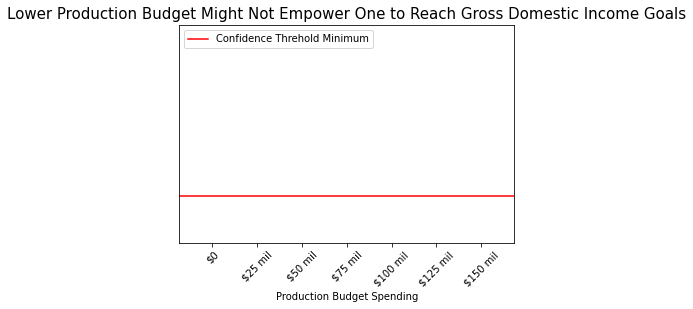

In [97]:
# Chart to show results of the first two statistcal tests + other similar numbers
data1 = {'$0' : 0,'$25 mil': 2, '$50 mil': 0, '$75 mil': 0, '$100 mil': 0, '$125 mil': 0, '$150 mil': 7.6}
names1 = list(data1.keys())
values1 = list(data1.values()) # values for $25 million and $150 million are dummy values 
#     so horizonal line remains in the same place as in the next chart

plt.bar(range(len(data1)), values1, tick_label=names1, color = 'w')
plt.axhline(y = 1.7, color = 'r', linestyle = '-', label = 'Confidence Threhold Minimum')
plt.xticks(rotation = 45)
plt.yticks([])
plt.tick_params(left=False)
#plt.ylabel('Confidence Score')
plt.xlabel('Production Budget Spending', fontsize=10)
plt.title('Lower Production Budget Might Not Empower One to Reach Gross Domestic Income Goals', fontsize=15)
plt.legend(loc = 'upper left')

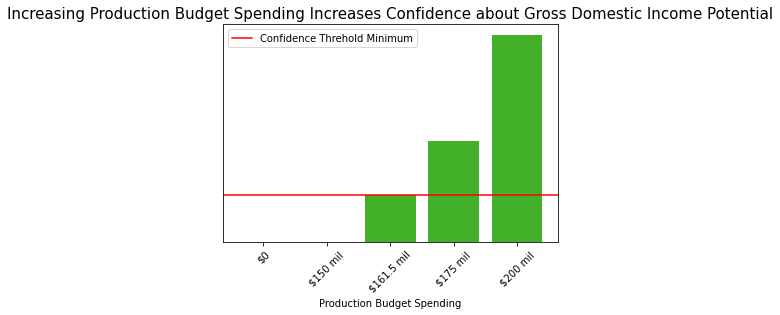

In [98]:
# Chart that shows how production budget increase will yield higher gross domestic income potential
import matplotlib.pyplot as plt

data = {'$0' : 0, '$150 mil':0, '$161.5 mil': 1.7, '$175 mil': 3.7, '$200 mil':7.6}
names = list(data.keys())
values = list(data.values())

plt.bar(range(len(data)), values, tick_label=names, color = '#43B02A')
plt.axhline(y = 1.7, color = 'red', linestyle = '-', label = 'Confidence Threhold Minimum')
plt.xticks(rotation = 45)
plt.yticks([])
plt.tick_params(left=False)
#plt.ylabel('Confidence Score')
plt.xlabel('Production Budget Spending', fontsize=10)
plt.title('Increasing Production Budget Spending Increases Confidence about Gross Domestic Income Potential', fontsize=15)
plt.legend(loc = 'upper left')
#plt.suptitle('The more production budget the more confidence gross domestic income will reach at least $99,478,358.79')
output_filename = './screenshots/prod_budget.png'
plt.savefig(output_filename)